Предобработка данных

In [11]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [12]:
# загружаем данные и и смотрим что у нас есть
df = pd.read_excel("data.xlsx", engine='openpyxl')

print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print("\nПримеры записей:")
print(df.head())
print("\nТипы данных:")
print(df.dtypes)

Количество строк: 1001
Количество столбцов: 214

Примеры записей:
   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone

In [ ]:
print("Анализ пропусков")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print(missing_df.sort_values(by='Missing %', ascending=False))



Анализ пропусков
                     Missing Count  Missing %
MinAbsPartialCharge              3     0.2997
BCUT2D_LOGPHI                    3     0.2997
BCUT2D_MWHI                      3     0.2997
MaxAbsPartialCharge              3     0.2997
MinPartialCharge                 3     0.2997
...                            ...        ...
SlogP_VSA5                       0     0.0000
SlogP_VSA6                       0     0.0000
SlogP_VSA7                       0     0.0000
SlogP_VSA8                       0     0.0000
fr_urea                          0     0.0000

[214 rows x 2 columns]


На основе результатов анализа пропусков видим:

1. У нас  214 признаков (столбцов). У большинства признаков нет пропусков (значение Missing Count = 0).
Лишь несколько столбцов имеют по 3 пропуска, что составляет 0.2997% от общего числа строк.
2.Процент пропущенных значений — менее 0.3%.
3.Так как пропусков мало (~0.3%), попробуем оставить их как есть.

In [14]:
print("Описательная статистика")

numeric_cols = df.select_dtypes(include=np.number).columns
print("\nСтатистика по числовым признакам:")
print(df[numeric_cols].describe())

categorical_cols = df.select_dtypes(exclude=np.number).columns
if not categorical_cols.empty:
    print("\nЧастотное распределение категориальных признаков:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts(normalize=True) * 100)
else:
    print("\nКатегориальные признаки отсутствуют.")

Описательная статистика

Статистика по числовым признакам:
        Unnamed: 0     IC50, mM     CC50, mM            SI  MaxAbsEStateIndex  \
count  1001.000000  1001.000000  1001.000000   1001.000000        1001.000000   
mean    500.000000   222.805156   589.110728     72.508823          10.831637   
std     289.108111   402.169734   642.867508    684.482739           3.307505   
min       0.000000     0.003517     0.700808      0.011489           2.321942   
25%     250.000000    12.515396    99.999036      1.433333           9.252350   
50%     500.000000    46.585183   411.039342      3.846154          12.179236   
75%     750.000000   224.975928   894.089176     16.566667          13.167843   
max    1000.000000  4128.529377  4538.976189  15620.600000          15.933463   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex          qed  \
count     1001.000000        1001.000000     1001.000000  1001.000000   
mean        10.831637           0.180681       -0.967237     0.58

Визуализация целевых переменных


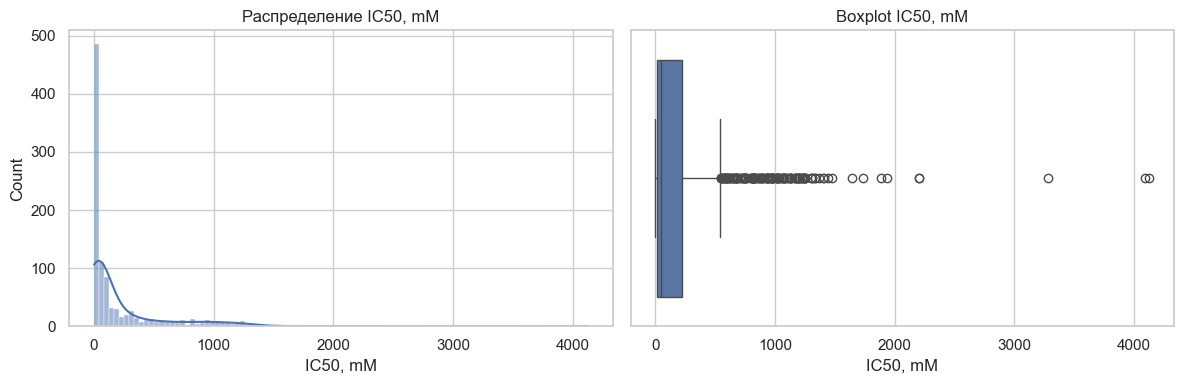

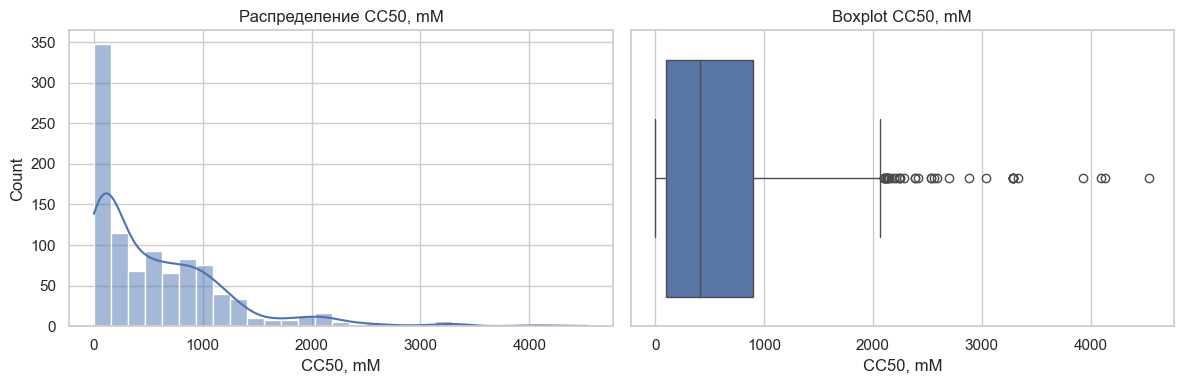

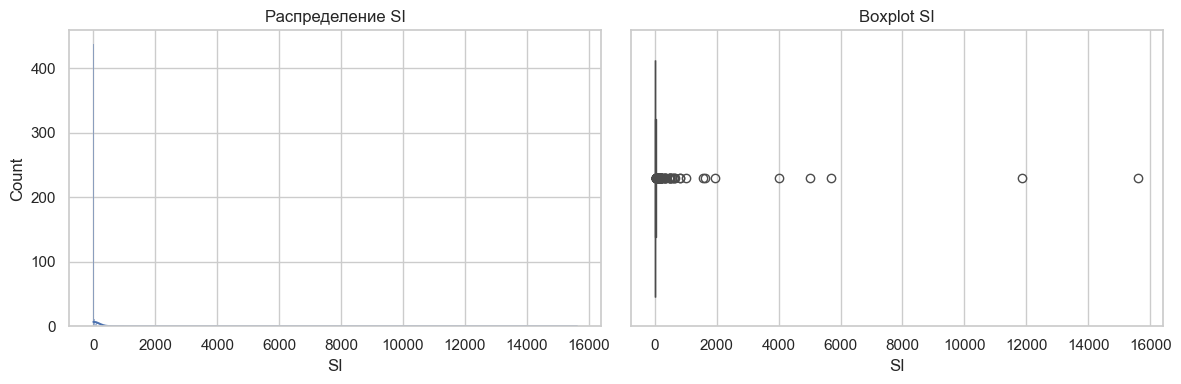

In [16]:
print("Визуализация целевых переменных")

targets = ['IC50, mM', 'CC50, mM', 'SI']
for target in targets:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[target], kde=True)
    plt.title(f'Распределение {target}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[target])
    plt.title(f'Boxplot {target}')
    plt.tight_layout()
    plt.show()

Взаимосвязь между целевыми переменными
Среднее отклонение SI от расчетного: 0.00
Первые 5 записей:
     IC50, mM    CC50, mM         SI  calculated_SI       si_diff
0    6.239374  175.482382  28.125000      28.125000  1.065814e-14
1    0.771831    5.402819   7.000000       7.000000  0.000000e+00
2  223.808778  161.142320   0.720000       0.720000  2.220446e-16
3    1.705624  107.855654  63.235294      63.235294  7.105427e-15
4  107.131532  139.270991   1.300000       1.300000  4.440892e-16


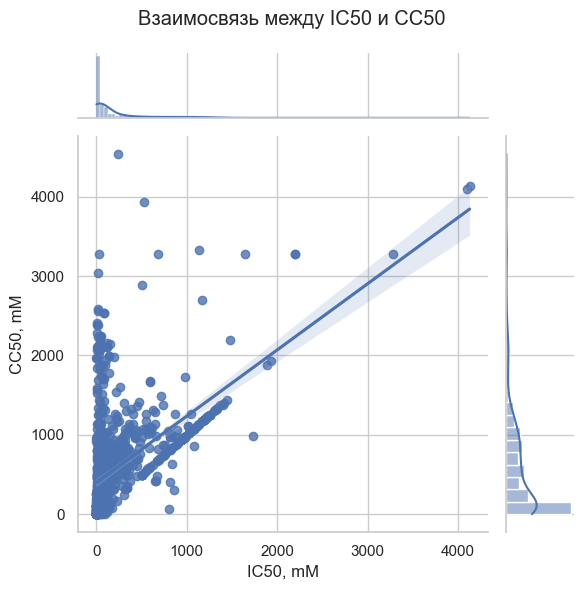

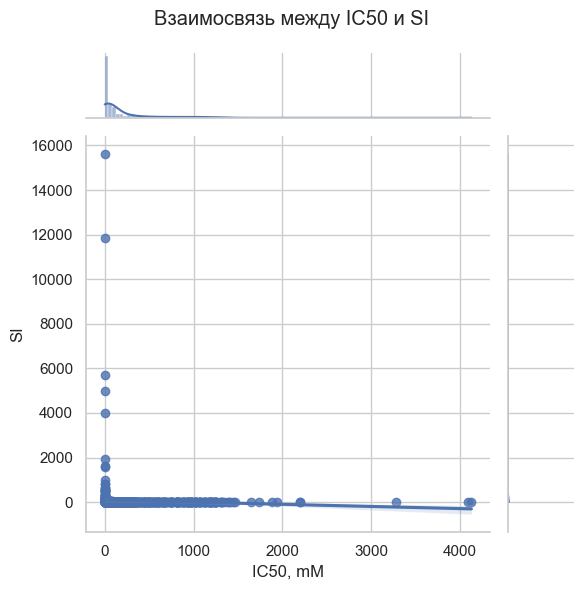

In [17]:
print("Взаимосвязь между целевыми переменными")

df['calculated_SI'] = df['CC50, mM'] / df['IC50, mM']
df['si_diff'] = abs(df['SI'] - df['calculated_SI'])

print(f"Среднее отклонение SI от расчетного: {df['si_diff'].mean():.2f}")
print("Первые 5 записей:")
print(df[['IC50, mM', 'CC50, mM', 'SI', 'calculated_SI', 'si_diff']].head())

sns.jointplot(data=df, x='IC50, mM', y='CC50, mM', kind='reg', height=6)
plt.suptitle('Взаимосвязь между IC50 и CC50')
plt.tight_layout()
plt.show()

sns.jointplot(data=df, x='IC50, mM', y='SI', kind='reg', height=6)
plt.suptitle('Взаимосвязь между IC50 и SI')
plt.tight_layout()
plt.show()

In [18]:
print("Поиск выбросов")

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers.sum(), outliers

outlier_count, _ = detect_outliers_iqr(df[numeric_cols])
print("Количество выбросов по IQR:")
print(outlier_count)

z_scores = np.abs(zscore(df[numeric_cols]))
outliers_z = (z_scores > 3).sum(axis=0)
print("\nКоличество выбросов по Z-score:")
print(outliers_z)

Поиск выбросов
Количество выбросов по IQR:
Unnamed: 0             0
IC50, mM             147
CC50, mM              39
SI                   125
MaxAbsEStateIndex     19
                    ... 
fr_thiazole           52
fr_thiocyan            0
fr_thiophene          70
fr_unbrch_alkane      50
fr_urea                7
Length: 214, dtype: int64

Количество выбросов по Z-score:
Unnamed: 0            0
IC50, mM             11
CC50, mM             18
SI                    5
MaxAbsEStateIndex     0
                     ..
fr_thiazole          52
fr_thiocyan           0
fr_thiophene         70
fr_unbrch_alkane     23
fr_urea               7
Length: 214, dtype: int64


1. Наблюдаем выбросы во многих признаках особенно таких как IC50, mM, SI, fr_thiazole, fr_thiophene.
Это может влиять на обучение моделей
2. Разница между IQR и Z-score объясняется типом распределения
Если данные не нормальны , метод Z-score будет менее строгим.
3. Некоторые фрагменты (например, fr_...) часто содержат выбросы
Это может быть связано с редкими структурами в молекулах.
Может быть полезным для моделирования (например, сигнализируют об уникальных свойствах).

Анализ мультиколенеарности


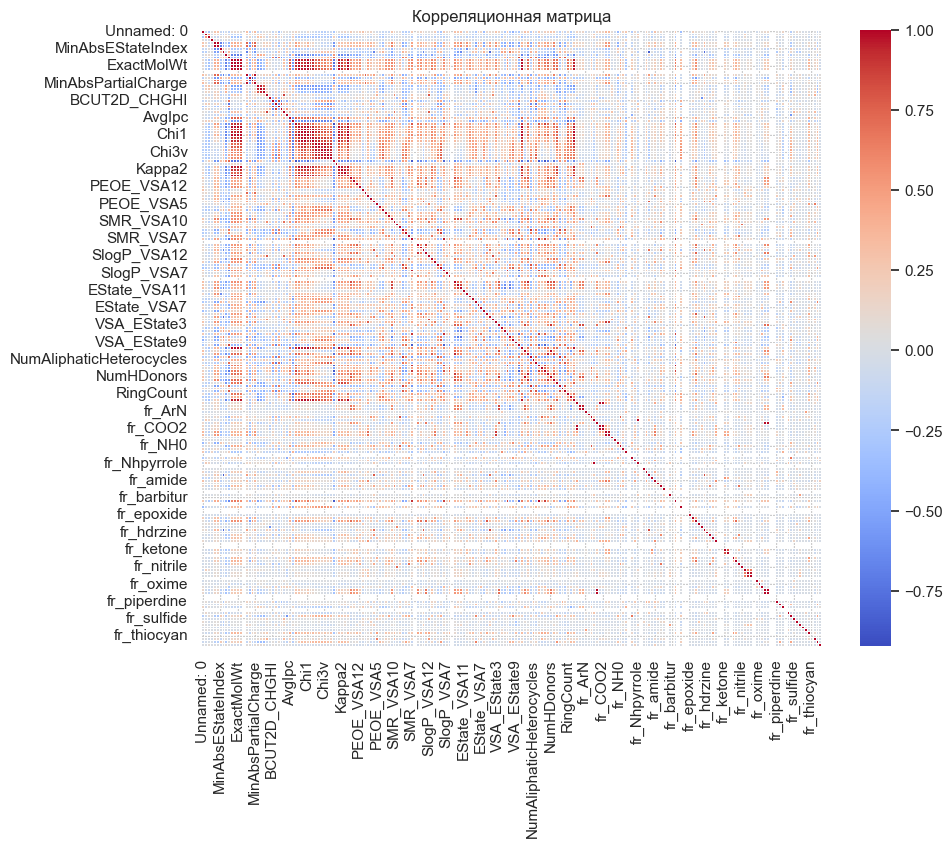

c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



VIF для числовых признаков:
               Feature           VIF
1           Unnamed: 0  7.178134e+00
2             IC50, mM  2.521468e+00
3             CC50, mM  2.972312e+00
4                   SI  1.167723e+00
5    MaxAbsEStateIndex  4.377443e+07
..                 ...           ...
210        fr_thiazole  1.639462e+01
211        fr_thiocyan           NaN
212       fr_thiophene  2.811134e+01
213   fr_unbrch_alkane  1.538304e+01
214            fr_urea  8.932173e+00

[214 rows x 2 columns]


In [19]:
print("Анализ мультиколенеарности")

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

X = add_constant(df[numeric_cols])

# Обработка inf и NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF для числовых признаков:")
print(vif_data[vif_data['Feature'] != 'const'])

Провёли анализ мультиколлинеарности с помощью VIF (Variance Inflation Factor)-это метрика, которая показывает, насколько сильно дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности

Интерпретация:
VIF = 1 → нет корреляции с другими признаками.
VIF < 5 → умеренная мультиколлинеарность (приемлемо).
VIF > 5–10 → высокая мультиколлинеарность → стоит удалить или объединить такие признаки.

MaxAbsEStateIndex
4.38e+07
Сильно коррелирует с другими признаками
fr_thiophene
28.1
Высокая мультиколлинеарность
fr_unbrch_alkane
15.4
Высокая мультиколлинеарность
fr_thiazole
16.4
Высокая мультиколлинеарность
Unnamed: 0
7.18
Умеренно высокая
fr_urea
8.93
Высокая
IC50, mM
CC50...
~2.5 – 2.9
Низкая мультиколлинеарность

1. Проблема высокой мультиколлинеарности есть
Некоторые признаки имеют очень высокие значения VIF , особенно:

MaxAbsEStateIndex: 43 млн — это явно проблема.
fr_thiophene, fr_thiazole, fr_unbrch_alkane и другие фрагменты (fr_...) тоже имеют VIF > 10.
Это значит, что:

Эти признаки сильной скоррелированы с другими , и их одновременное использование в моделях может привести к:
Неустойчивости коэффициентов,
Переобучению,
Снижению интерпретируемости модели.
2. Ключевые параметры (IC50, CC50, SI) не имеют сильной мультиколлинеарности
Их VIF ≈ 1–3 → это хорошо.
Можно использовать их как целевые переменные или предикторы без опасений.


Общие выводы по EDA:
1. Признаки IC50, CC50 и SI имеют явные выбросы.
2. SI коррелирует с отношением CC50 / IC50.
3. Высокая корреляция между некоторыми фичами может влиять на обучение моделей.
4. Необходимо масштабировать данные перед обучением моделей.
